Este colab fue desarrollado por Arnold Charry Armero.

# Bosques Aleatorios (Clasificación)

Los Bosques Aleatorios (Random Forests) son un algoritmo de ensamble basado en la construcción de múltiples Árboles de Decisión. Su funcionamiento se apoya en la técnica de Bagging (Bootstrap Aggregating), que consiste en generar distintas muestras de entrenamiento mediante remuestreo con reemplazo (Bootstrap). Cada árbol del bosque se entrena con una de estas muestras, lo que introduce diversidad entre los modelos y contribuye a reducir la varianza (Velasco Rebolledo, 2024). Además del bagging, los Bosques Aleatorios incorporan un segundo mecanismo de aleatoriedad: en cada división de un árbol, no se consideran todas las variables disponibles, sino un subconjunto aleatorio de características. Este procedimiento aumenta la diversidad entre árboles y evita que todos se centren en las mismas variables dominantes, mejorando la capacidad de generalización del modelo. De acuerdo con estudios empíricos, los mejores tamaños de subconjuntos de variables son $ \sqrt{m}$, $  \frac{m}{3} $ o $ \log_{2}(m+1) $, pero claramente eso depende de cada base de datos y se confirma cuál tamaño es el mejor con Grid Search (James, Witten, Hastie, & Tibshirani, 2021).

En problemas de clasificación cada árbol emite un voto por una clase, y la clase predicha por el Bosque Aleatorio corresponde a la que recibe la mayoría de votos. Matemáticamente se define de la siguiente manera,

$$
\hat{C}_{bag}(x) = \arg\max_{k \in \{1, \dots, K\}}
\left( \sum_{b=1}^{B} I\big(\hat{C}^{*b}(x) = k\big) \right)
$$

Una de las grandes ventajas de este método es que no produce sobreajuste y disminuye la varianza. Sin embargo, si se utilizan demasiados árboles, se tendrán posiblemente árboles repetidos que no agreguen valor a la nueva predicción y, además, aumenten la correlación entre árboles.

Ahora se continúa con la implementación en código,

In [ ]:
# Se importan las librerias
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/accident.csv')

In [ ]:
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


Primero se analiza la base de datos,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [ ]:
df.describe()

,Age,Speed_of_Impact,Survived
count,200.00000,197.000000,200.00000
mean,43.42500,70.441624,0.50500
std,14.94191,30.125298,0.50123
min,18.00000,20.000000,0.00000
25%,31.00000,43.000000,0.00000
50%,43.50000,71.000000,1.00000
75%,56.00000,95.000000,1.00000
max,69.00000,119.000000,1.00000


Se contabiliza las personas que sobrevivieron y las que no,

In [ ]:
df['Survived'].value_counts()

,count
Survived,
1,101
0,99


Como se puede observar que los datos de supervivencia están como tipo númerico, es preferible pasarlos a tipo string.

In [ ]:
# Opción 1: convertir a string
df["Survived"] = df["Survived"].astype(str)

## Preprocesamiento de Datos

Se verifica a ver el tema de los faltantes,

In [ ]:
df.isnull().sum()[df.isnull().sum() != 0]

,0
Gender,1
Speed_of_Impact,3


Se visualizan las distribuciones para seleccionar si imputar por media o mediana,

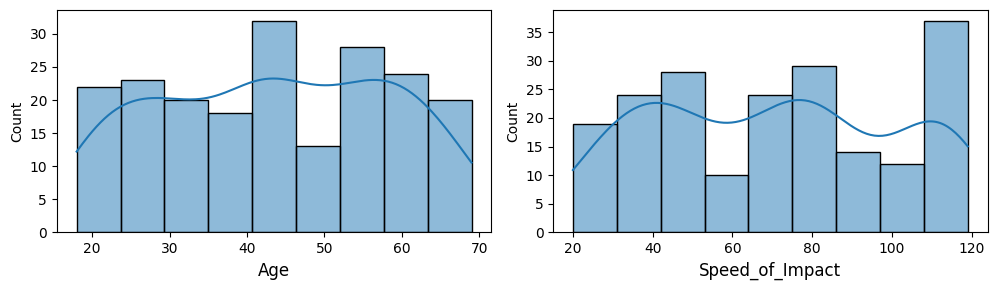

In [ ]:
# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=['number']).columns
n = len(num_cols)

cols = 4
rows = mt.ceil(n / cols)

plt.figure(figsize=(cols*5, rows*3))

for i, column in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[column], kde=True)
    plt.xlabel(column, fontsize=12)

plt.tight_layout()
plt.show()

Se imputa por mediana, ya que los datos están muy dispersos en Speed_of_Impact.

In [ ]:
# Tratamiento de valores faltantes
target_col = df.columns[-1]

for col in df.columns:
    if df[col].isnull().any():
        if col == target_col:
            imputer = SimpleImputer(strategy='most_frequent')
        elif is_numeric_dtype(df[col]):
            valores_unicos = df[col].dropna().unique()
            if set(valores_unicos).issubset({0, 1}) and len(valores_unicos) <= 2:
                imputer = SimpleImputer(strategy='most_frequent')
            else:
                imputer = SimpleImputer(strategy='median')
        elif is_object_dtype(df[col]) or is_string_dtype(df[col]):
            imputer = SimpleImputer(strategy='most_frequent')
        else:
            continue

        # Imputar y reemplazar
        df[col] = imputer.fit_transform(df[[col]]).ravel()

Se vuelve a revisar el tema de los faltantes,

In [ ]:
df.isnull().sum()[df.isnull().sum() != 0]

,0


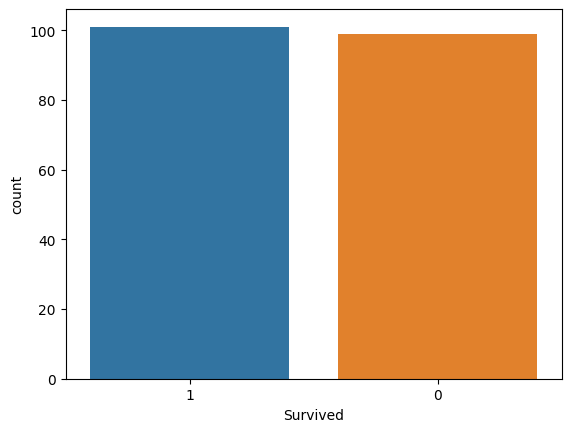

In [ ]:
# Gráfico de barras por cada clase
sns.countplot(data=df,x='Survived', hue='Survived')
plt.show()

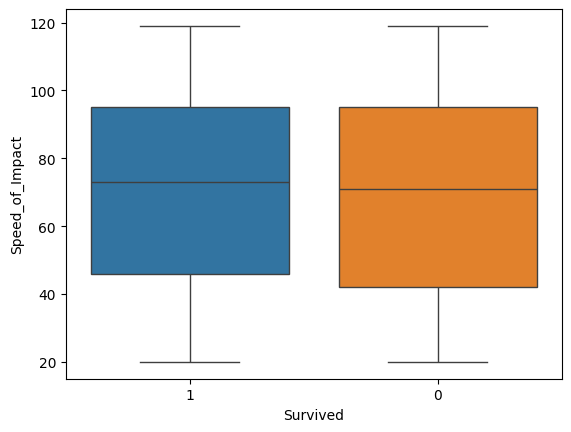

In [ ]:
# Gráfico de caja
sns.boxplot(x='Survived',y='Speed_of_Impact',data=df, hue='Survived')
plt.show()

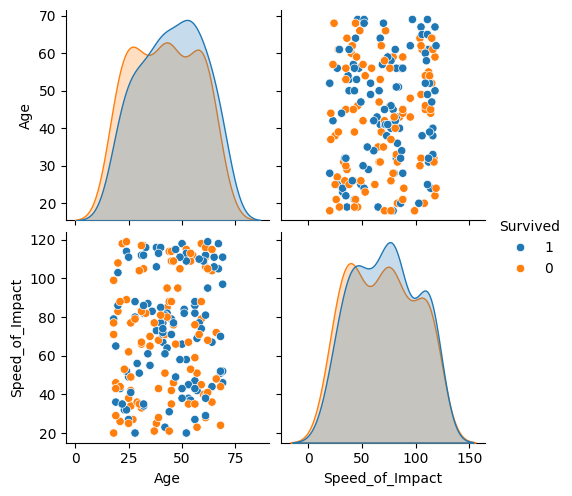

In [ ]:
sns.pairplot(df,hue='Survived')
plt.show()

In [ ]:
# Obtenemos las características
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop(df.columns[-1])
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Escalado de Datos

In [ ]:
# Se escalan las variables y se hace one-hot encoder
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Visualizar el array X_train
print(X_train)

[[1 0 0 60 109.0]
 [0 1 0 58 77.0]
 [1 0 1 44 114.0]
 [1 1 0 41 67.0]
 [1 0 1 32 82.0]
 [0 0 1 56 59.0]
 [0 0 1 68 44.0]
 [1 1 0 45 88.0]
 [0 1 0 62 105.0]
 [0 1 1 44 31.0]
 [0 1 0 67 105.0]
 [1 0 1 50 38.0]
 [0 0 1 21 88.0]
 [1 0 1 54 37.0]
 [0 1 1 59 74.0]
 [0 1 1 25 25.0]
 [1 0 1 29 56.0]
 [0 0 0 52 20.0]
 [0 1 1 62 68.0]
 [1 1 1 68 24.0]
 [1 1 1 46 46.0]
 [0 1 1 51 84.0]
 [0 1 1 56 86.0]
 [0 0 1 47 115.0]
 [1 1 1 56 35.0]
 [1 0 1 31 117.0]
 [0 1 1 49 111.0]
 [0 0 1 64 104.0]
 [0 0 1 42 23.0]
 [1 1 0 64 67.0]
 [0 0 1 55 112.0]
 [0 0 1 64 115.0]
 [1 1 1 18 71.0]
 [1 0 1 45 79.0]
 [1 1 1 28 80.0]
 [0 0 1 44 21.0]
 [1 1 0 66 48.0]
 [1 1 1 38 116.0]
 [0 1 1 39 43.0]
 [1 1 1 58 71.0]
 [0 1 1 60 40.0]
 [0 1 0 59 118.0]
 [1 1 1 31 67.0]
 [1 0 0 22 35.0]
 [0 1 1 41 72.0]
 [0 0 1 18 20.0]
 [0 0 1 28 88.0]
 [0 1 0 52 58.0]
 [1 1 0 34 87.0]
 [1 1 1 43 80.0]
 [1 1 1 56 88.0]
 [0 0 0 56 27.0]
 [1 0 1 20 103.0]
 [1 0 0 43 95.0]
 [1 1 0 23 32.0]
 [0 1 1 26 49.0]
 [1 0 1 34 61.0]
 [1 0 1 38 73.0]
 

## Entrenamiento del Modelo

Ahora vamos con el modelo Random Forest,

In [ ]:
Random_Forest_model = RandomForestClassifier(n_estimators = 100, max_features = "sqrt", random_state = 0)
Random_Forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Realizando una predicción,


In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", Random_Forest_model.predict(ct.transform([[69, 'Female',	46.0, 'Yes', 'Yes']]))[0])

Predicción: 1


In [ ]:
# Obtenemos las predicciones
y_pred = Random_Forest_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[['1']
 ['1']
 ['0']
 ['1']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['1']
 ['0']
 ['0']
 ['0']
 ['1']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['0']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['0']
 ['1']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['0']
 ['0']
 ['1']]


## Rendimiento del Modelo

In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.5166666666666667


In [ ]:
# Matriz de confusión
confusion_matrix(y_test,y_pred)

array([[14, 19],
       [10, 17]])

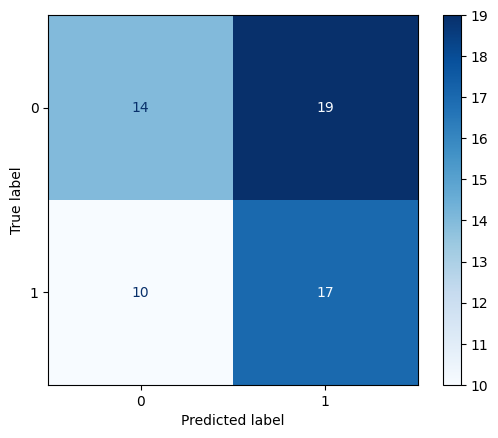

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.42      0.49        33
           1       0.47      0.63      0.54        27

    accuracy                           0.52        60
   macro avg       0.53      0.53      0.52        60
weighted avg       0.53      0.52      0.51        60



## Validación Cruzada y Grid Search

In [ ]:
# Aplicar K-fold Cross Validation
accuracies = cross_val_score(estimator = Random_Forest_model, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
print(accuracies.mean())

0.4642857142857143


Se conocen los parámetros del Bosque Aleatorio para evaluar el GridSearch.

In [ ]:
Random_Forest_model = RandomForestClassifier(random_state = 0)

In [ ]:
# Parámetros
Random_Forest_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', 0.33]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = Random_Forest_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'accuracy',
                                  n_jobs = -1,
                                  verbose = 2)

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'max_features': ['sqrt', 'log2', 0.33],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=2)

In [ ]:
print(full_cv_classifier.best_params_)

{'max_depth': None, 'max_features': 0.33, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Se obtiene el mejor resultado
print(full_cv_classifier.best_score_)

0.5214285714285714


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = RandomForestClassifier(n_estimators = 300, max_depth = None, max_features = 0.33, min_samples_leaf = 1,
                              min_samples_split = 2)
model.fit(X_train,y_train)

RandomForestClassifier(max_features=0.33, n_estimators=300)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[['1']
 ['1']
 ['0']
 ['1']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['1']
 ['0']
 ['0']
 ['1']
 ['1']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['0']
 ['0']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['0']
 ['0']
 ['1']
 ['0']
 ['1']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['0']
 ['1']
 ['0']
 ['0']
 ['1']]


In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.45


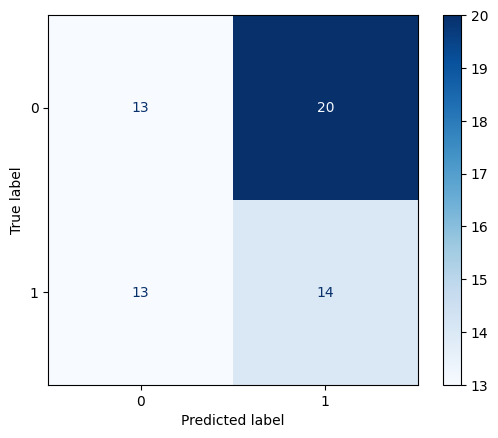

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.39      0.44        33
           1       0.41      0.52      0.46        27

    accuracy                           0.45        60
   macro avg       0.46      0.46      0.45        60
weighted avg       0.46      0.45      0.45        60



Mirando las características más importantes,

In [ ]:
features = model.feature_importances_

In [ ]:
# DataFrame con la importancia
feats = pd.DataFrame(index = df.columns[:-1], data = features, columns = ["Importance"])

In [ ]:
display(feats)

,Importance
Age,0.050334
Gender,0.039835
Speed_of_Impact,0.051007
Helmet_Used,0.415550
Seatbelt_Used,0.443273


In [ ]:
imp_feats = feats[feats['Importance'] > 0]

In [ ]:
# Ordenar de mayor a menor
imp_feats = imp_feats.sort_values(by='Importance', ascending=False)

Se imprime un gráfico con las características más importantes,

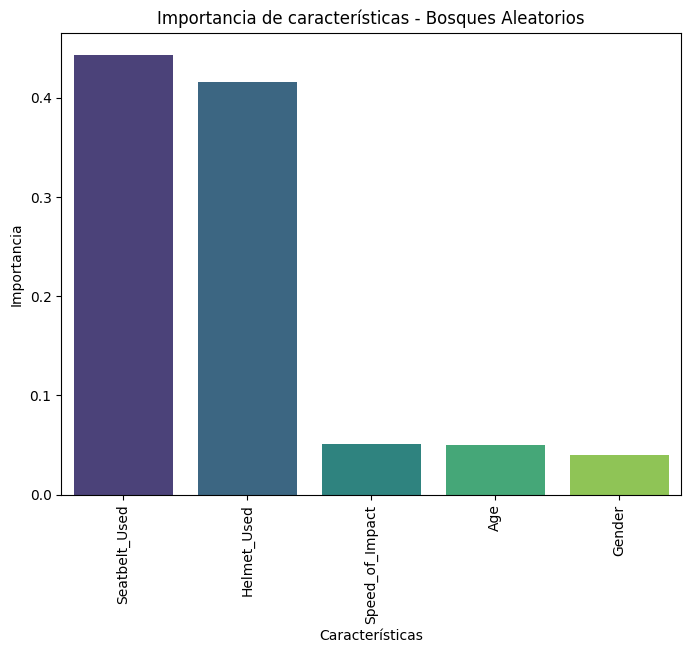

In [ ]:
plt.figure(figsize = (8, 6))
sns.barplot(data = imp_feats, x = imp_feats.index, y = 'Importance', hue = imp_feats.index, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de características - Bosques Aleatorios")
plt.show()

## Referencias

*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*   Road Accident Survival Dataset. (2025, January 18). Kaggle. https://www.kaggle.com/datasets/himelsarder/road-accident-survival-dataset
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.